# ★ Interpolation ★

In [48]:
# Import modules
import sys
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy import linalg

# 3.1 Data And Interpolating Functions

## Newton's divided differences

In [71]:
def newton_divided_diff(X, Y, n):
    V = {}
    for j in range(n):
        V[j, 0] = Y[j]
    
    for i in range(1,n):
        for j in range(n-i):
            V[j, i] = (V[j+1, i-1] - V[j, i-1]) / (X[j+i] - X[j])
    
    C = np.zeros(n)
    for i in range(n):
        C[i] = V[0,i]
    
    return C

### Example 
Use Newton's divided differences to find the interpolating polynomial passing through (0,2),(1,1),(2,0),(3,-1)

In [72]:
X = [0, 1, 2, 3]
Y = [2, 1, 0, -1]
C = newton_divided_diff(X, Y, 4)
print(C)

[ 2. -1.  0.  0.]


$$
P(x) = 2 + (-1)(x - 0) = 2 - x
$$

# 3.3 Chebyshev Interpolation

In [73]:
def chebyshev_interpolation_nodes(a, b, n):
    X = np.zeros(n)
    
    for i in range(1,n + 1):
        X[i - 1] = (b + a) / 2 + (b - a) / 2 * math.cos( (2 * i - 1) * math.pi / (2 * n) )
        
    return X

### Example
Use chebyshev interpolating polynomial to evaluate the function $f(x) = \sin{(x)}$

In [145]:
def interpolating_polynomial(X, Y, x):
    while x >= math.pi * 2:
        x -= (2 * math.pi)
    C = newton_divided_diff(X, Y, X.size)
    poly = 0
    for i in range(C.size):
        mul = 1
        for j in range(0, i):
            mul *= (x - X[j])
        poly += (C[i] * mul)
        
    return poly

In [292]:
X = chebyshev_interpolation_nodes(0, 2 * math.pi, 8)
Y = np.sin(X)

In [293]:
x = 1
poly = interpolating_polynomial(X, Y, x)
print('chebyshev : %.15f' %poly)
print('real sin  : %.15f' %math.sin(x))
print('error     : %.15f' %abs(math.sin(x) - poly))

chebyshev : 0.841135018496244
real sin  : 0.841470984807897
error     : 0.000335966311653


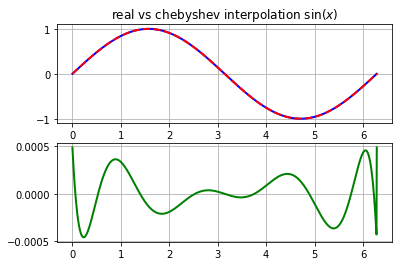

In [294]:
pX = np.linspace(0, 2 * math.pi, 1024)
pY = np.zeros(1024)
for i in range(pX.size):
    pY[i] = interpolating_polynomial(X, Y, pX[i])

real_sin_y = np.sin(pX)
error_y = real_sin_y - pY
plt.subplot(211)
plt.title('real vs chebyshev interpolation $\sin{(x)}$')
plt.plot(pX, pY, color='b',linewidth=2)
plt.plot(pX, real_sin_y, color='r', linestyle='--',linewidth=2)
plt.grid(True)
plt.subplot(212)
plt.plot(pX, error_y, color='g', linewidth=2)
plt.grid(True)
plt.show()

# 3.4 Cubic Splines

## Natural cubic spline

In [3]:
def natural_cubic_spline(X, Y):
    A = np.zeros(X.size - 1, dtype=float)
    for i in range(X.size - 1):
        A[i] = Y[i]
    delta = np.zeros(X.size - 1, dtype=float)
    Delta = np.zeros(X.size - 1, dtype=float)
    for i in range(1, X.size):
        delta[i - 1] = X[i] - X[i - 1]
        Delta[i - 1] = Y[i] - Y[i - 1]
        
    Mat = np.zeros(X.size * X.size, dtype=float).reshape(X.size, X.size)
    Mat[0][0] = Mat[X.size - 1][X.size - 1] = 1.0
    for i in range(1, X.size - 1):
        Mat[i][i] = 2 * (delta[i - 1] + delta[i]) #diagonal
        Mat[i][i - 1] = delta[i - 1]
        Mat[i][i + 1] = delta[i]
        
    b = np.zeros(X.size, dtype=float)
    for i in range(1,X.size - 1):
        b[i] = 3 * (Delta[i]/delta[i] - Delta[i - 1]/delta[i - 1])
    
    # Solve the equations systems
    lu, piv = linalg.lu_factor(Mat)
    C = linalg.lu_solve([lu, piv], b)
    
    D = np.zeros(X.size - 1, dtype=float)
    B = np.zeros(X.size - 1, dtype=float)
    
    for i in range(1, X.size):
        D[i - 1] = (C[i] - C[i - 1]) / (3 * delta[i - 1])
        B[i - 1] = Delta[i - 1] / delta[i - 1] - delta[i - 1] * (2 * C[i - 1] + C[i]) / 3
        
    return A, B, C, D

### Example
Find the natural cubic spline through (0,3),(1,-2),(2,1)

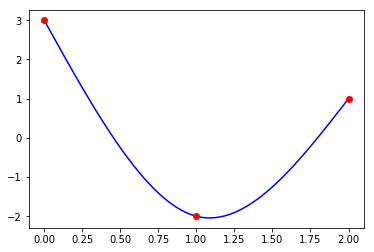

In [126]:
X = np.array([0, 1, 2])
Y = np.array([3, -2, 1])
A, B, C, D = natural_cubic_spline(X, Y)
S = lambda x, i : A[i] + B[i] * (x - X[i]) + C[i] * pow(x - X[i], 2) + D[i] * pow(x - X[i], 3)
total = 200
pX = np.linspace(0,2,total)
pY = np.zeros(total)
for i in range(pX.size):
    x = pX[i]
    for j in range(X.size - 1):
        if x <= X[j + 1]:
            pY[i] = S(x, j)
            break
        else:
            continue
    
plt.plot(pX,pY,color='b')
plt.plot(X,Y,'ro')
plt.show()

### Example
Cubic splines with six points (0,3),(1,1),(2,4),(3,1),(4,2),(5,0)

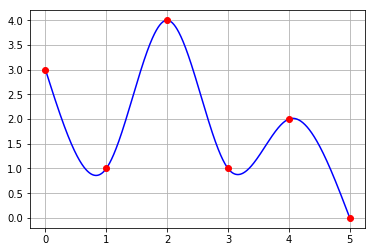

In [4]:
X = np.array([0, 1, 2, 3, 4, 5])
Y = np.array([3, 1, 4, 1, 2, 0])
A, B, C, D = natural_cubic_spline(X, Y)
S = lambda x, i : A[i] + B[i] * (x - X[i]) + C[i] * pow(x - X[i], 2) + D[i] * pow(x - X[i], 3)
total = 1000
pX = np.linspace(0,5,total)
pY = np.zeros(total)
for i in range(pX.size):
    x = pX[i]
    for j in range(X.size - 1):
        if x <= X[j + 1]:
            pY[i] = S(x, j)
            break
        else:
            continue
    
plt.plot(pX,pY,color='b')
plt.plot(X,Y,'ro')
plt.grid(True)
plt.show()

# 3.5 Bézier Curves

In [38]:
def bezier_curve(X, Y):
    """
    Make the function handle of the bezier curve formula
    
    Args:
        X - x-axis points (include endpoints and control points)
        Y - y-axis points (include endpoints and control points)
        
    Returns:
        fx - bezier curve for x-axis points
        fy - bezier curve for y-axis points
    """
    x1 = X[0]
    x2 = X[1]
    x3 = X[2]
    x4 = X[3]
    y1 = Y[0]
    y2 = Y[1]
    y3 = Y[2]
    y4 = Y[3]
    
    bx = 3 * (x2 - x1)
    cx = 3 * (x3 - x2) - bx
    dx = x4 - x1 - bx - cx
    by = 3 * (y2 - y1)
    cy = 3 * (y3 - y2) - by
    dy = y4 - y1 - by - cy
    
    fx = lambda t : x1 + bx * t + cx * pow(t, 2) + dx * pow(t, 3)
    fy = lambda t : y1 + by * t + cy * pow(t, 2) + dy * pow(t, 3)
    
    return fx, fy

### Example
Find the Bézier curve $(x(t),y(t))$ through the points $(x,y) = (1,1)$ and $(2,2)$ with control points $(1,3)$ and $(3,3)$

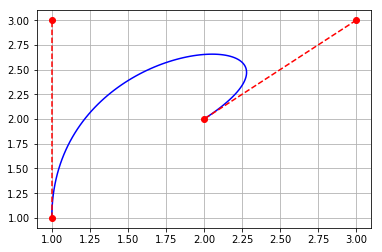

In [47]:
X = np.array([1, 1, 3, 2])
Y = np.array([1, 3, 3, 2])
fx, fy = bezier_curve(X, Y)

t = np.linspace(0, 1, 100)
px = fx(t)
py = fy(t)

plt.plot(px, py, color='b')
plt.plot(X[0:2], Y[0:2], color='r', marker='o', linestyle='--')
plt.plot(X[2:4], Y[2:4], color='r', marker='o', linestyle='--')
plt.grid(True)
plt.show()